In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

# Uncomment the follwing line to enabled devlib debugging statements
# logging.getLogger('ssh').setLevel(logging.DEBUG)

In [2]:
# Generate plots inline
%matplotlib inline

import copy
import json
import os
import time

# Support to access the remote target
import devlib
from env import TestEnv

# Support to configure and run RTApp based workloads
from wlgen import RTA

# Support for performance analysis of RTApp workloads
from perf_analysis import PerfAnalysis

# Support for trace events analysis
from trace import Trace

# Suport for FTrace events parsing and visualization
import trappy

Populating the interactive namespace from numpy and matplotlib


# Test environment setup

In [3]:
# Setup a target configuration
my_target_conf = {
    
    # Define the kind of target platform to use for the experiments
    "platform"    : 'linux',  # Linux system, valid other options are:
                              # android - access via ADB
                              # linux   - access via SSH
                              # host    - direct access
    
    # Preload settings for a specific target
    "board"       : 'juno',   # load JUNO specific settings, e.g.
                              # - HWMON based energy sampling
                              # - Juno energy model
                              # valid options are:
                              # - juno  - JUNO Development Board
                              # - tc2   - TC2 Development Board
                              # - oak   - Mediatek MT63xx based target

    # Define devlib module to load
    "modules"     : [
        'bl',           # enable big.LITTLE support
        'cpufreq',      # enable CPUFreq support
    ],

    # Account to access the remote target
    "host"        : '192.168.0.10',
    "username"    : 'root',
    "password"    : '',


    # Comment the following line to force rt-app calibration on your target
    "rtapp-calib" : {
        '0': 361, '1': 138, '2': 138, '3': 352, '4': 360, '5': 353
    }

}

# Setup the required Test Environment supports
my_tests_conf = {
        
    # Binary tools required to run this experiment
    # These tools must be present in the tools/ folder for the architecture
    "tools"   : ['trace-cmd'],
    
    # FTrace events buffer configuration
    # events listed here MUST be 
    "ftrace"  : {
        
        
##############################################################################
# EVENTS SPECIFICATIPON
##############################################################################
# Here is where we specify the list of events we are interested into:
# Events are of two types:
# 1. FTrace tracepoints that _must_ be supported by the target's kernel in use.
#    These events will be enabled at ftrace start time, thus if the kernel does
#    not support one of them, ftrace starting will fails.

        "events" : [
            "sched_switch",
            "cpu_frequency",
        ],

# 2. FTrace events generated via trace_printk, from either kernel or user
#    space. These events are different from the previous because they do not
#    need to be explicitely enabled at ftrace start time.
#    It's up to the user to ensure that the generated events satisfies these
#    formatting requirements:
#    a) the name must be a unique word into the trace
#    b) values must be reported as a sequence of key=value paires
#    For example, a valid custom event string is:
#      my_math_event: kay1=val1 key2=val2 key3=val3

        "custom" : [
            "my_math_event",
        ],
        
# For each of these events, TRAPpy will generate a Pandas dataframe accessible
# via a TRAPpy::FTrace object, whith the same name of the event.
# Thus for example, ftrace.my_math_event will be the object exposing the
# dataframe with all the event matching the "my_math_event" unique word.
        
##############################################################################
        
         "buffsize" : 10240,
    },

}

In [4]:
# Initialize a test environment using:
# the provided target configuration (my_target_conf)
# the provided test configuration (my_test_conf)
te = TestEnv(target_conf=my_target_conf, test_conf=my_tests_conf)
target = te.target

05:26:51  INFO    :         Target - Using base path: /home/derkling/Code/schedtest
05:26:51  INFO    : %14s - Loading custom (inline) target configuration
05:26:51  INFO    :         Target - Connecting linux target with: {'username': 'root', 'host': '192.168.0.10', 'password': ''}
05:26:55  INFO    :         Target - Initializing target workdir [/root/devlib-target]
05:26:58  INFO    : Target topology: [[0, 3, 4, 5], [1, 2]]
05:27:00  INFO    :         FTrace - Enabled events:
05:27:00  INFO    :         FTrace -   ['sched_switch', 'cpu_frequency']
05:27:00  INFO    :    EnergyMeter - HWMON module not enabled
05:27:00  WARNING :    EnergyMeter - Energy sampling disabled by configuration


In [5]:
logging.info("Target ABI: %s, CPus: %s",
             target.abi,
             target.cpuinfo.cpu_names)

05:27:00  INFO    : Target ABI: arm64, CPus: ['A53', 'A57', 'A57', 'A53', 'A53', 'A53']


# Example of custom event definition

In [6]:
# Define the format string for the custom events we will inject from user-space
my_math_event_fmt = "my_math_event: sin={} cos={}"

# Start FTrace
te.ftrace.start()

# Let's generate some interesting "custom" events from userspace
logging.info('Generating events from user-space (will take ~140[s])...')
for angle in range(360):
    v_sin = int(1e6 * math.sin(math.radians(angle)))
    v_cos = int(1e6 * math.cos(math.radians(angle)))
    my_math_event = my_math_event_fmt.format(v_sin, v_cos)
    # custom events can be generated either from userspace, like in this
    # example, or also from kernelspace (using a trace_printk call)
    target.execute('echo {} > /sys/kernel/debug/tracing/trace_marker'\
                   .format(my_math_event))

# Stop FTrace
te.ftrace.stop()

05:27:05  INFO    : Generating events from user-space (will take ~140[s])...


In [7]:
# Collect the generate trace
trace_file = '/tmp/trace.dat'
te.ftrace.get_trace(trace_file)

In [8]:
# Parse trace
events_to_parse = my_tests_conf['ftrace']['events'] + my_tests_conf['ftrace']['custom']
trace = Trace(te.platform, '/tmp', events_to_parse)

05:29:37  INFO    : Collected events spans a 146.767 [s] time interval


# Inspection of the generated TRAPpy FTrace object

In [9]:
# Get the TRAPpy FTrace object which has been generated from the trace parsing
ftrace = trace.ftrace

In [10]:
# The FTrace object allows to verify which (of the registered) events have been
# identified into the trace
logging.info("List of events identified in the trace:\n%s",
             ftrace.class_definitions.keys())

05:29:37  INFO    : List of events identified in the trace:
['cpu_frequency', 'sched_switch', 'my_math_event']


In [11]:
# Each event identified in the trace is appended to a table (i.e. data_frame)
# which has the same name of the event

logging.info("First 10 events of our 'my_math_event' custom event:")
ftrace.my_math_event.data_frame.head(10)

05:29:37  INFO    : First 10 events of our 'my_math_event' custom event:


,__comm,__cpu,__pid,cos,sin
Time,,,,,
0.465916,sh,0,30563,1000000,0
0.869805,sh,0,30563,999847,17452
1.273996,sh,0,30563,999390,34899
1.677924,sh,0,30563,998629,52335
2.082107,sh,0,30563,997564,69756
2.486149,sh,4,30563,996194,87155
2.890237,sh,4,30563,994521,104528
3.295050,sh,4,30563,992546,121869
3.699198,sh,4,30563,990268,139173


In [12]:
logging.info("First 10 events of our 'cpu_frequency' tracepoint:")
ftrace.cpu_frequency.data_frame.head(10)

05:29:37  INFO    : First 10 events of our 'cpu_frequency' tracepoint:


,__comm,__cpu,__pid,cpu,frequency
Time,,,,,
0.000000,kworker/0:2,0,30494,0,575000
0.000009,kworker/0:2,0,30494,3,575000
0.000014,kworker/0:2,0,30494,4,575000
0.000019,kworker/0:2,0,30494,5,575000
0.016023,kworker/0:2,0,30494,0,450000
0.016034,kworker/0:2,0,30494,3,450000
0.016042,kworker/0:2,0,30494,4,450000
0.016048,kworker/0:2,0,30494,5,450000
0.017447,kworker/2:2,2,30600,1,450000


# Plotting tracepoint and/or custom events

/home/derkling/.local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


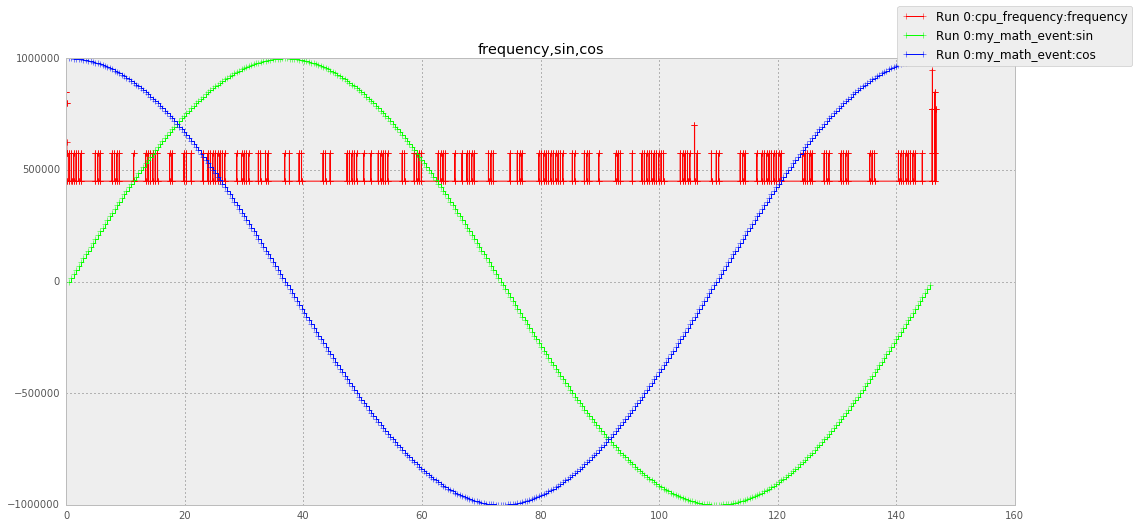

In [13]:
# It is possible to mix in the same plot tracepoints and custom events

# The LinePlot module requires to specify a list of signals to plot.
# Each signal is defined as:
#       <event>:<column>
# where:
#  <event>   is one of the events collected from the trace by the FTrace object
#  <column>  is one of the column of the previously defined event
my_signals = [
    'cpu_frequency:frequency',
    'my_math_event:sin',
    'my_math_event:cos'
]

# These two paramatere are passed to the LinePlot call as long with the
# TRAPpy FTrace object
trappy.LinePlot(
    ftrace,                      # FTrace object
    signals=my_signals,          # Signals to be plotted
    drawstyle='steps-post',      # Plot style options
    marker = '+'
).view()